**Goal:   Find manually a depth-range `drange` (min, max) values for the scattering intensity reconstruction.**

Reconstruction will add a new dimension (depth along beam) in any requested X-ray detector pixel (i.e pixels in ROI centered on Laue spots). For any pixel having this extra dimension, the element is called voxel.

Since zero depth may be inaccurate (even after wire trajectories calibration step), and the computation time increases with the nb of voxels,  `drange` (min value, max value) (in mm) and `ystep` (in mm) must fit rather the region where reconstructed signal is non zero. (grain or grains location).

In this notebook, by choosing 1 Laue spots we may adapt the shorter `drange_narrow` allowing the reconstruction of voxel scattering intensity of the corresponding grain.  

To handle larger depth for the reconstruction (to get deeper grains) or several daxm scan measured at different sample height of the specimen with a tilted surface (e.g. about 40 degrees on BM32), a larger range will be necessary. In this notebook this is called `drange_large` and must be used afterwards as input parameter of reconstruction in rec.py script#

**ybeam positive towards sample depth (and along the beam propagation direction)**

recspot, depth = rec.interpolate(drange_narrow)



# imports

In [1]:
import LaueTools.Daxm.classes.scan as LTDaxmsc
LTDaxmsc.__file__

-- warning: Missing library libtiff, Please install: pylibtiff if you need open some tiff images. However, Fabio or PIL can do the job!


'/home/micha/lauetoolsgithub/LaueTools/Daxm/classes/scan/__init__.py'

In [2]:
# tested on python 3.8 and 3.6

#----------- global imports -----------
import os, sys

print(f'you are using python {sys.version}')
if sys.version_info.minor>=8:
    %matplotlib ipympl
    try:
        import ipympl
    except:
        print('You need to install ipympl: pip install ipympl')
else:
    %matplotlib notebook

import matplotlib as mpl
import matplotlib.pylab as mplp

import numpy as np

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

you are using python 3.8.0 (default, Nov  6 2019, 21:49:08) 
[GCC 7.3.0]


In [3]:
#----------- daxm imports -----------
from LaueTools.Daxm.classes.scan import new_scan
from LaueTools.Daxm.classes.source import new_source
from LaueTools.Daxm.classes.calibration import CalibManager
from LaueTools.Daxm.classes.reconstruction import SpotReconstructor

import LaueTools.Daxm.classes.scan as LTdcs
LTdcs.__file__


location photutils <module 'photutils' from '/home/micha/anaconda3/envs/py38NN/lib/python3.8/site-packages/photutils/__init__.py'>


'/home/micha/lauetoolsgithub/LaueTools/Daxm/classes/scan/__init__.py'

In [4]:
# a helper function to visualise 3D data and correspond 2D slices
def fig_slider(vol, axis=2, datacontent='XYdepth'): # or YXdepth
    
    vol = np.array(vol)  # 3D data
    
    assert vol.ndim ==3
    
    #widget = widgets.IntSlider(min=0, max=vol.shape[axis]-1, step=1, value=0)
    
    mplp.figure(figsize=(5,3))
    
    if axis==0:
        img0 = vol[0, :, :]
    elif axis==1:
        img0 = vol[:, 0, :]
    else:
        img0 = vol[:, :, 0]
    
    ax = mplp.imshow(np.flipud(img0), vmin=np.min(vol), vmax=np.mean(vol) + 3.*np.std(vol), origin="upper")
    mplp.colorbar()

    if axis==2 and datacontent == 'XYdepth':
        mplp.xlabel('detector pixel X')
        mplp.ylabel('detector pixel Y')
        
    if axis==0:
        
        mplp.xlabel('depth index ')
        mplp.ylabel('detector pixel X')
        
    if axis==1:
        
        mplp.xlabel('depth index ')
        mplp.ylabel('detector pixel Y')
        
    def update_img(idx=0):
        if axis==0:
            img = vol[idx, :, :]
        elif axis==1:
            img = vol[:, idx, :]
        else:
            img = vol[:, :, idx]
        if axis==2 and datacontent == 'XYdepth':
            mplp.title('pixel intensity (changing depth index=%d)'%idx)
        
        ax.set_data(img)
    
    #return interact(update_img, idx=widget)
    return interact(update_img, idx=(0, vol.shape[axis]-1))

# user settings (DAXM analysis  calibration and reconstruction)

In [10]:
#---------Ge (calib by fluorescence and to reconstruction) -- all directories -----------
if 1:

    analysis_dir = "/home/micha/LaueProjects/DAXMSept21/GeDAXM"
    calib_dir = os.path.join(analysis_dir, "calibration")
    recdir = os.path.join(analysis_dir, "reconstruction")
    prefix = "GeDAXM"

    #----------- scan and calib -----------
    #scan = new_scan(os.path.join(analysis_dir, prefix+".scan"))  # for mesh of wire scans
    print('analysis_dir',analysis_dir)

    #import LaueTools
    #print('LT',LaueTools.__file__)


    scan = new_scan(os.path.join(analysis_dir, prefix+"_calib.scan"))

    #scan.set_verbosity(False)

    calib = CalibManager(prefix+".calib", yref=y_calib, directory=calib_dir)

    sample = new_source("Ge", 0.02)


# #--------ZrO2--- all directories -----------
if 0:
   
    # analysis_dir = "/media/micha/LaCie/a322847_guillou_daxm/ech13/ech13_map2d3d/scan_0002"
    # calib_dir = os.path.join(analysis_dir, "calibration")
    # recdir = os.path.join(analysis_dir, "reconstruction")
    # prefix = "ech13_daxm_0"

    #----------- scan and calib -----------
    #scan = new_scan(os.path.join(analysis_dir, prefix+".scan"))  # for mesh of wire scans
    print('analysis_dir',analysis_dir)

    #import LaueTools
    #print('LT',LaueTools.__file__)


    #scan = new_scan(os.path.join(analysis_dir, prefix+"_calib.scan"))
    filescan = 'ech13_daxm_0.scan'

    scan = new_scan(os.path.join(analysis_dir, filescan))

    #scan.set_verbosity(False)

    calib = CalibManager(prefix+".calib", yref=y_calib, directory=calib_dir)

    #
    sample = new_source("Ge", 0.05)   #Zr02 has the same ~ density as Ge


wmin, wmax = scan.wire_position[0],scan.wire_position[-1]
print('extreme positions of wire motor yf or zf',wmin, wmax)

analysis_dir /home/micha/LaueProjects/DAXMSept21/GeDAXM
"scan_inp" scan input dict /home/micha/LaueProjects/DAXMSept21/GeDAXM/GeDAXM_calib.scan
/home/micha/LaueProjects/DAXMSept21/GeDAXM/GeDAXM_calib.scan 
#######     read .scan file  ############
"scan_inp" scan input dict {'type': 'point', 'size': 0, 'skipFrame': 0, 'lineSubFolder': False, 'specFile': '/home/micha/LaueProjects/DAXMSept21/laue.01Sep21', 'scanNumber': 28, 'hdf5scanId': '', 'scanCmd': [1.3, 2.0, 700, 0.9], 'CCDType': 'sCMOS', 'detCalib': '/home/micha/LaueProjects/DAXMSept21/GeDAXM/calibGe001.det', 'wire': [['W', 0.025, 0.94, 2.1399999999999997], ['W', 0.025, 1.2, 1.59], ['W', 0.025, 0.9, 1.05]], 'wireTrajAngle': 0.0, 'imageFolder': '/home/micha/LaueProjects/DAXMSept21/GeDAXM', 'imagePrefix': 'GeDAXM_', 'imageFirstIndex': 0, 'imageDigits': 4, 'imageOffset': 0.0, 'monitor': 'spec', 'monitorROI': [], 'monitorOffset': 13}
[scan] Creating class instance...
Creating class instance... (init StaticPointScan)
input "inp" {'type'

In [11]:
#----------- useful parameters for several wire scans set -----------

#xgrid = np.arange(-0.007, 0.008, 0.001)
#ygrid = np.arange(-0.004, 0.016, 0.002)

# for single daxm scan analysis (reconstruction) 
xgrid = np.array([0.,])
ygrid = np.array([0.,])

# zero depth origin correction for analysis daxm scan data measured at different vertical (yech) sample point
# `y_calib` is the relative daxm scan current sample position height (perp to incoming beam) or distance yech (40 degrees tilted)
# unit (index? or mm ?) to wires trajectories calibration point.
# see RecManager and set_grid of wire trajectories
# For single scan of daxm used for calibration (by fluo) and for reconstruction: y_calib = 0
y_calib = 0 

# visualisation of Laue pattern. Wire shadowing

interactive(children=(IntSlider(value=0, description='imageindex', max=700), IntSlider(value=0, description='v…

<function __main__.update_img(imageindex=0, vmin=0.0, vmax=1891, showbox=False)>

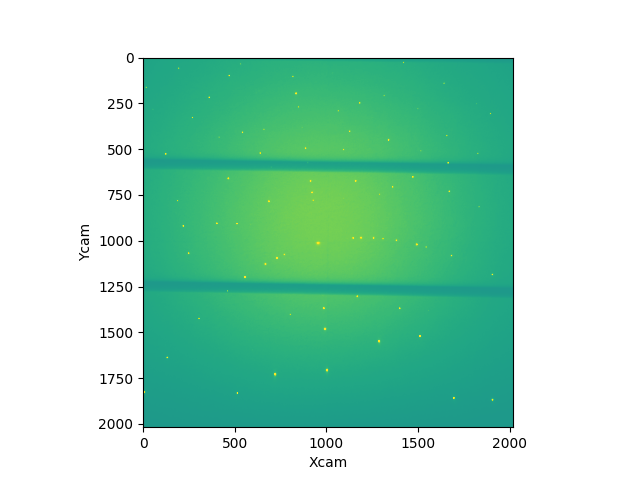

In [93]:
#%matplotlib notebook  python 3.6
%matplotlib ipympl


# Choose 1 pixel  (X, Y) coordinates, boxsize, and energy
#----------- spot to analyse ---ZrO2-------
XYcam = [969, 806]  # 27 microns
XYcam = [1083, 880]  # 30 microns

#----------- spot to analyse ---Ge-------
XYcam = [953, 1005]  
XYcam = [1491, 1021] 
XYcam = [465, 662] 
#XYcam = [1285, 1550] 

# -----   ROI for fluo  ----------
#XYcam = [954, 806]  

halfboxsize = [7, 13]
# guessed photon energy Laue spots to fine modelling of incoming beam intensity attenuation
E = 11
#--------------------------------------------------------

# ------------------------------

imageindex0 = 0
img0 = scan.get_image(imageindex0)

c1 = int(np.mean(img0, axis=(0, 1))) + 4 * int(np.std(img0, axis=(0, 1)))
vmin0, vmax0 = scan.img_offset, int(c1)

figplot, ax = mplp.subplots()
ax.plot([XYcam[0] - halfboxsize[0], XYcam[0] + halfboxsize[0],
           XYcam[0] + halfboxsize[0], XYcam[0] - halfboxsize[0],
           XYcam[0] - halfboxsize[0]],
          [XYcam[1] - halfboxsize[1], XYcam[1] - halfboxsize[1],
           XYcam[1] + halfboxsize[1], XYcam[1] + halfboxsize[1],
           XYcam[1] - halfboxsize[0]], 'r')
ax.set_xlim(0,2018)
ax.set_ylim(2018,0)
#
# ax.imshow(img.transpose(), origin='upper', vmin=vmin, vmax=vmax)

# mplp.xlim([0, self.get_img_params(['framedim'])[0]])
# mplp.ylim([0, self.get_img_params(['framedim'])[1]])

# ax.set_xlabel("Xcam")
# ax.set_ylabel("Ycam")

# compute incoming beam intensity attenuation
abscoeff = sample.calc_absorption(E)

def update_img(imageindex=imageindex0, vmin=vmin0, vmax=vmax0,showbox=False):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.clear()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_xlabel("Xcam")
    ax.set_ylabel("Ycam")
    img = scan.get_image(imageindex)
#     c1 = int(np.mean(img, axis=(0, 1))) + 4 * int(np.std(img, axis=(0, 1)))
#     vmin, vmax = scan.img_offset, int(c1)
    if showbox:
        ax.plot([XYcam[0] - halfboxsize[0], XYcam[0] + halfboxsize[0],
           XYcam[0] + halfboxsize[0], XYcam[0] - halfboxsize[0],
           XYcam[0] - halfboxsize[0]],
          [XYcam[1] - halfboxsize[1], XYcam[1] - halfboxsize[1],
           XYcam[1] + halfboxsize[1], XYcam[1] + halfboxsize[1],
           XYcam[1] - halfboxsize[0]], 'r')
    
    ax.imshow(img.transpose(), origin='upper', vmin=vmin, vmax=vmax)
    # plot a red box around peak XYcam
    
    
    
interact(update_img, imageindex=(0, scan.number_images-1),
         vmin=(0,1000), vmax=(1001,50000,20),
         showbox=[True, False])

# reconstruction of 1 Laue spot (or fluorescence)

In [94]:
#----------- Create reconstructor   (ybeam in microns) -----------
# test value of depth  to have a dip 
# adapt the size to catch top baseline before and after the dip
drange_large  = [0,.06]  

if max(drange_large) - min(drange_large)<0.05:
    print('Warning: For a 50 µm wire diameter, drange is too small to catch a full dip')
    print('')

# if 'scan' correspond to a set of daxm scan (2D sample mesh of daxm scan or 1D line of daxm scan)
# uncomment and select daxm scan
#scan.goto_centre()
#scan.goto(iy=0)
#scan.goto(iy=9)
#wire = calib.get_wires(ygrid[scan.get_current()[1]])

wire = calib.get_wires()

rec = SpotReconstructor(scan, XYcam, halfboxsize, drange_large, abscoeff, wire=wire)

print('For the chosen depth range `drange` (mm):',drange_large)
print('nb of voxels in depth available for reconstruction (from available wire scan images data):', rec.frames_cor.shape[2])
print('wire step size (mm) %.5f'%scan.wire_step)

For the chosen depth range `drange` (mm): [0, 0.06]
nb of voxels in depth available for reconstruction (from available wire scan images data): 119
wire step size (mm) 0.00100


In [95]:
selectedwireindex = rec.init_wire_assign()

print(f'Y pixel Range of shadowing for the {len(wire)} wires')
for kk, ww in enumerate(rec.scan.calc_wires_range_scan(wire=wire)):
    print(f'wire {kk} : from Y = {ww[0]:.2f}  to  {ww[1]:.2f}')

print(f'For current pixel at X,Y={XYcam[0]},{XYcam[1]}: ')
print(f'AUTOMATIC Selection of wire #{selectedwireindex} over', list(range(len(wire))))

Y pixel Range of shadowing for the 3 wires
wire 0 : from Y = 0.00  to  786.23
wire 1 : from Y = 576.12  to  1386.91
wire 2 : from Y = 1244.25  to  2010.00
For current pixel at X,Y=465,662: 
AUTOMATIC Selection of wire #0 over [0, 1, 2]


In [96]:
# difference ????
rec.wire.p0, [ww.p0 for ww in wire]

(2.1399999999999997,
 [2.152754617901238, 1.5981004989673453, 0.9830475595528103])

In [97]:
zfpos_imageindex = np.array([rec.scan.spec_data.zf, rec.scan.img_idx]).T
zfpos_imageindex

array([[  1.2999983,   0.       ],
       [  1.3009944,   1.       ],
       [  1.3020022,   2.       ],
       ...,
       [  1.9980025, 698.       ],
       [  1.9989986, 699.       ],
       [  1.9999947, 700.       ]])

In [98]:
import LaueTools.Daxm.modules.geometry as geom

def get_imageindex_from_depth(depth, XYcam, rec):
    """get image index"""
    pcam = geom.transf_pix_to_coo(rec.scan.get_ccd_params(), XYcam[0], XYcam[1])
    #_wire = rec.wire
    _wire = wire[selectedwireindex]
    wiremotor_pos = _wire.intersect_ray_axis(depth, pcam)
    print('scanned motor zf or yf position : ', wiremotor_pos)
    return np.searchsorted(zfpos_imageindex[:,0], wiremotor_pos)

get_imageindex_from_depth(0,XYcam, rec)

scanned motor zf or yf position :  1.918542437194937


619

((119,), (119,))

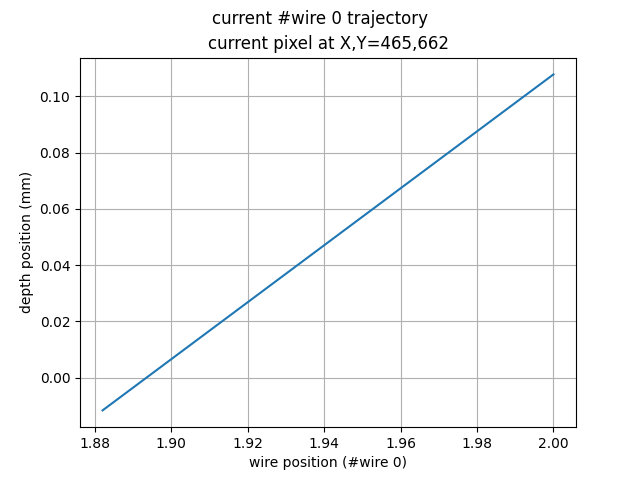

In [99]:
figwtraj, axwtraj = mplp.subplots()
figwtraj.suptitle(f'current #wire {selectedwireindex} trajectory')
axwtraj.plot(rec.pw, rec.yw)
axwtraj.grid()
axwtraj.set_xlabel(f'wire position (#wire {selectedwireindex})')
axwtraj.set_ylabel(f'depth position (mm)')
axwtraj.set_title(f'current pixel at X,Y={XYcam[0]},{XYcam[1]}')


def format_getimageindex(x,y):
    if x >= min(rec.pw) and x < max(rec.pw):
        ydepth = np.interp(x, rec.pw, rec.yw)
        img_idx = int(get_imageindex_from_depth(ydepth,XYcam, rec))
        return "x=%1.4f, y=%1.4f, imageid=%d" % (x, y, img_idx)
    else:
        return "x=%1.4f, y=%1.4f" % (x, y)
axwtraj.format_coord = format_getimageindex

rec.yw.shape, rec.pw.shape

In [100]:
#rec.pw

## GUI to select properly a depth range `drange` to see pixel intensity dip (or shadowing)

Text(1.94099665, 18842.68650187304, 'depth axis')

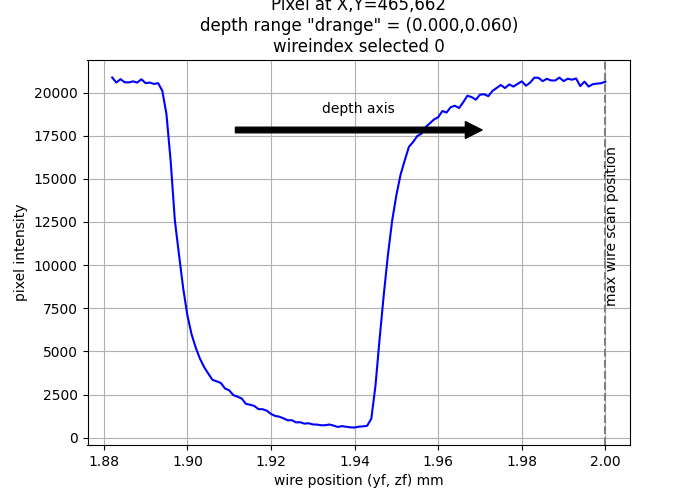

In [101]:
# ---------------visualisation ----------
title = f'Experimental range of wire position: [{wmin:.2f},{wmax:.2f}]\n'
title += f'Pixel at X,Y={XYcam[0]},{XYcam[1]}\n'
title += 'depth range "drange" = (%.3f,%.3f)\n'%(drange_large[0],drange_large[1])
title += f'wireindex selected {selectedwireindex}'
Xplot, Yplot = rec.pw, np.max(rec.frames_cor, axis=(0,1,))
mplp.figure(figsize=(7,5))
ax=mplp.plot(Xplot, Yplot, 'b')
mplp.title(title)
mplp.xlabel('wire position (yf, zf) mm')
mplp.ylabel('pixel intensity')
mplp.grid()
ax = mplp.gca()
ax.axvline(wmax, ls='--', c='grey')
ax.axvline(wmin, ls='--', c='grey')
meanYplot = np.mean(Yplot)
ax.text(wmin, meanYplot, 'min wire scan position', rotation=90, va='center')
ax.text(wmax, meanYplot, 'max wire scan position', rotation=90, va='center')
rangepw = max(rec.pw)-min(rec.pw)
midpw = .5*(max(rec.pw)+min(rec.pw))
ax.set_xlim(midpw-1.1*rangepw/2.,midpw+1.1*rangepw/2.)
ax.annotate('', xytext=(0.75*min(rec.pw)+0.25*max(rec.pw), .85*max(Yplot)+.15*min(Yplot)),
            xy=(0.25*min(rec.pw)+0.75*max(rec.pw), .85*max(Yplot)+.15*min(Yplot)),
            arrowprops=dict(facecolor='black'))
ax.text(midpw, .9*max(Yplot)+.1*min(Yplot), 'depth axis', rotation=0, ha='center')
#mplp.figure()
#mplp.plot(scan.img_idx,scan.get_monitor())



In [102]:
rec.frames_cor.shape

(15, 27, 119)

interactive(children=(IntSlider(value=0, description='idx', max=118), Output()), _dom_classes=('widget-interac…

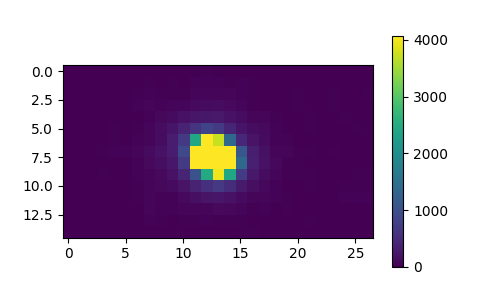

In [103]:
# plot of pixel intensities as a function of image index
aaa = fig_slider(rec.frames_cor, axis=2, datacontent=None)

## reconstruction of depth distribution of intensity

In [104]:
#----------- Reconstruction --------!!! can take time !!!--
rec.reconstruct(regularize=True)
drange_narrow = drange_large
#drange_narrow = [0.0, 0.08]  # depth (// aling incoming beam) in mm for reconstruction of scattering intensity

# ybeam positive towards sample depth

In [105]:
recspot, depth = rec.interpolate(drange_narrow, ystep=0.001)

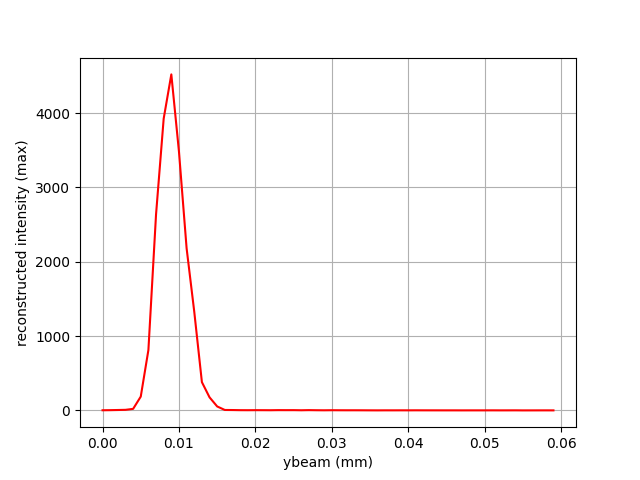

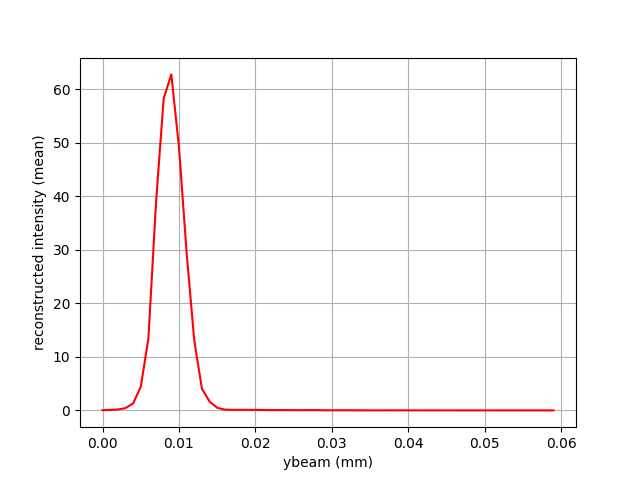

In [106]:
#----------- AFTER reconstruction -----------
fig = mplp.figure()
mplp.plot(depth, np.max(recspot, axis=(0,1,)), 'r')
ax = fig.gca()

ax.set_xlabel('ybeam (mm)')
ax.set_ylabel('reconstructed intensity (max)')
ax.grid()

fig2 = mplp.figure()
mplp.plot(depth, np.mean(recspot, axis=(0,1,)), 'r')
ax2 = fig2.gca()
ax2.set_xlabel('ybeam (mm)')
ax2.set_ylabel('reconstructed intensity (mean)')
ax2.grid()


recspot.shape (15, 27, 60)


interactive(children=(IntSlider(value=0, description='idx', max=59), Output()), _dom_classes=('widget-interact…

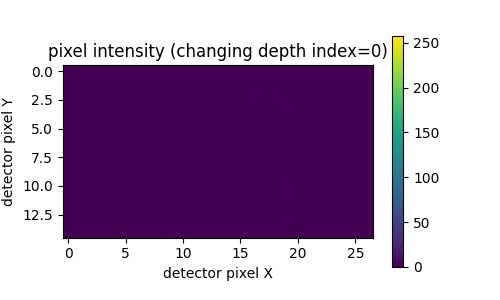

In [107]:
# vertical = horizontal pixel 2*halfboxsize[0] ,  horizontal = vertical 2*halfboxsize[1] pixel
# slider     idx  = micron  drange narrow
print('recspot.shape',recspot.shape)
xy = fig_slider(recspot)



interactive(children=(IntSlider(value=0, description='idx', max=14), Output()), _dom_classes=('widget-interact…

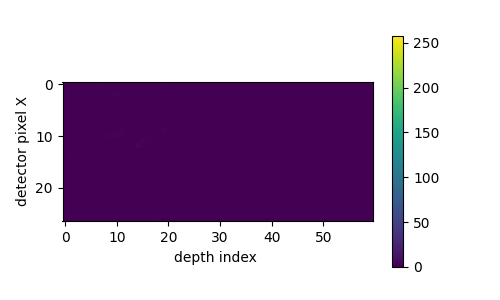

In [108]:
# vertical  pixel  2*halfboxsize[1], horizontal idx  = micron  drange narrow

XdepthY = fig_slider(recspot, axis=0)




interactive(children=(IntSlider(value=0, description='idx', max=26), Output()), _dom_classes=('widget-interact…

<function __main__.fig_slider.<locals>.update_img(idx=0)>

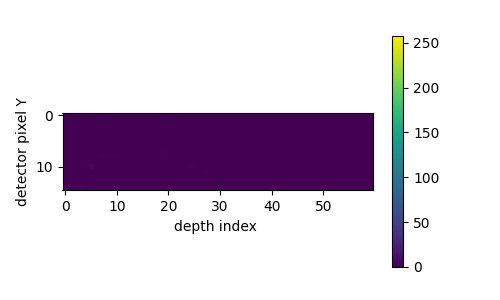

In [111]:
# horizontal  pixel  2*halfboxsize[0], horizontal idx  = micron  drange narrow

fig_slider(recspot, axis=1)

In [110]:
print('drange_large=',drange_large)
print('drange_narrow=',drange_narrow)

drange_large= [0, 0.06]
drange_narrow= [0, 0.06]


In [113]:
# crude way to build depth resolved Laue spot on a first corner of full image

import LaueTools.Daxm.utils.write_image as wimg    

fn_format = "{}_{{:0>{:d}d}}".format('test_rec', 4)

full_img = np.zeros((2018,2016))

n1, n2, n3 = recspot.shape

for i in range(recspot.shape[2]):
    full_img[:n2,:n1] = recspot[:,:,i].T
    wimg.write_image(full_img, fn_format.format(i + 0),
                    CCDLabel='sCMOS', dirname=recdir, verbose=1)

Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0000.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0001.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0002.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0003.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0004.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0005.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0006.tif.
Wrote 2018x2016 image with sCMOS format in /home/micha/LaueProjects/DAXMSept21/GeDAXM/reconstruction/test_rec_0007.tif.
Wrote 2018x2016 image with sCMOS format 